In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.insert(0, '..')
%matplotlib inline

USE_GPU = torch.cuda.is_available()
print "Using GPU?", USE_GPU

from torch.autograd import Variable
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('white')

from learn_smc_proposals import cde
from learn_smc_proposals.examples import factorial_hmm

Using GPU? False


# Factorial HMM

Example synthetic data: 20 different "devices", each with different power consumptions, turning on and off following separate Markov models

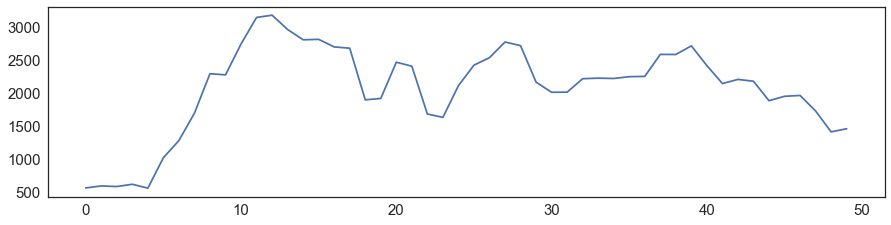

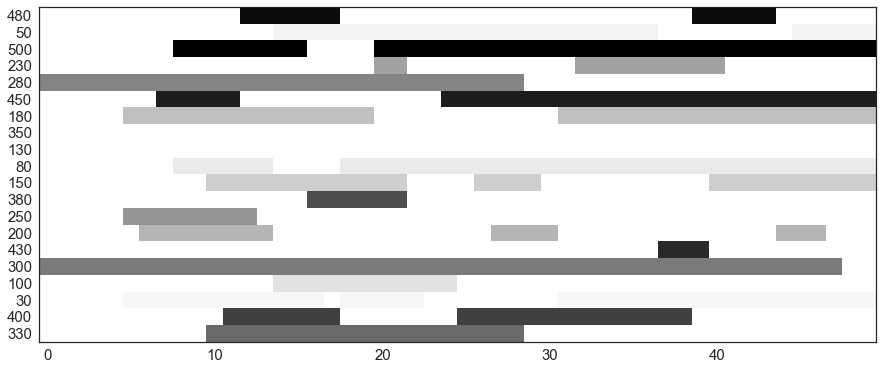

In [2]:
devices = factorial_hmm.gen_devices()
T = 50

np.random.seed(20)
X, Y = factorial_hmm.gen_dataset(devices, T)

plt.figure(figsize=(15,3.5))
plt.plot(Y)
plt.figure(figsize=(15,10))
plt.imshow((X*devices).T, interpolation='None', aspect=1);
plt.yticks(np.arange(len(devices)), devices);

In [3]:
print len(devices), 2**len(devices)

20 1048576


In [4]:
trace_train = []
trace_validation = []

dist_est = cde.ConditionalBinaryMADE(len(devices)+1, len(devices), H=300, num_layers=4)
if USE_GPU:
    dist_est.cuda()


In [5]:
dist_est.load_state_dict(torch.load('../saved/trained_hmm_params.rar'))

## Test out learned distribution inside of SMC

We'll compare it against a baseline of "bootstrap" SMC, which proposes from the transition dynamics of the individual HMMs.

In [6]:
X_hat_bootstrap, ancestry_bootstrap, ESS_bootstrap = \
    factorial_hmm.run_smc(devices, Y, 500, factorial_hmm.baseline_proposal, verbose=False)
Y_hat_bootstrap = np.dot(X_hat_bootstrap, devices)

In [7]:
nn_proposal = factorial_hmm.make_nn_proposal(dist_est)
X_hat_nn, ancestry_nn, ESS_nn = \
    factorial_hmm.run_smc(devices, Y, 500, nn_proposal, verbose=False)
Y_hat_nn = np.dot(X_hat_nn, devices)

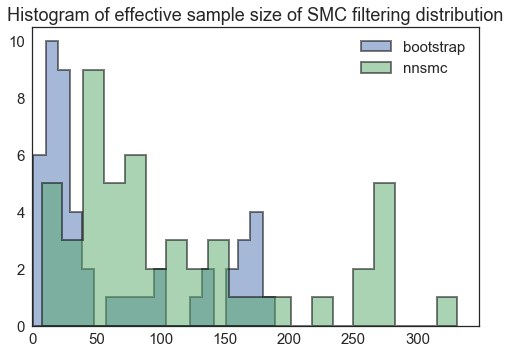

In [8]:
plt.hist(ESS_bootstrap, histtype='stepfilled', linewidth=2, alpha=0.5, bins=20,edgeColor='k')
plt.hist(ESS_nn, histtype='stepfilled', linewidth=2, alpha=0.5, bins=20,edgeColor='k')
plt.xlim([0,plt.xlim()[1]])
plt.legend(['bootstrap', 'nnsmc'])
plt.title('Histogram of effective sample size of SMC filtering distribution');

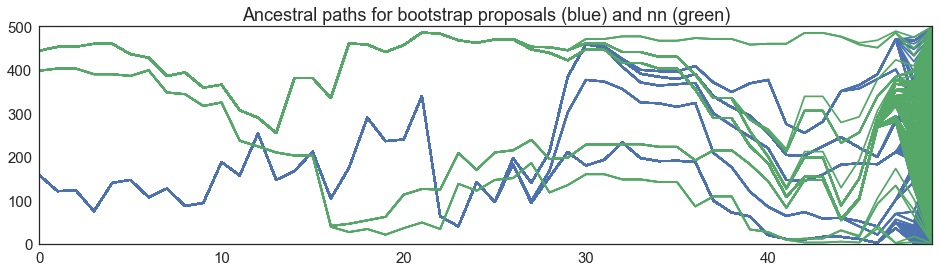

In [9]:
plt.figure(figsize=(16,4))
plt.title('Ancestral paths for bootstrap proposals (blue) and nn (green)')
plt.plot(ancestry_bootstrap.T, color=sns.color_palette()[0]);
plt.plot(ancestry_nn.T, color=sns.color_palette()[1]);
plt.ylim(0,ancestry_nn.shape[0])
plt.xlim(0,T-1);

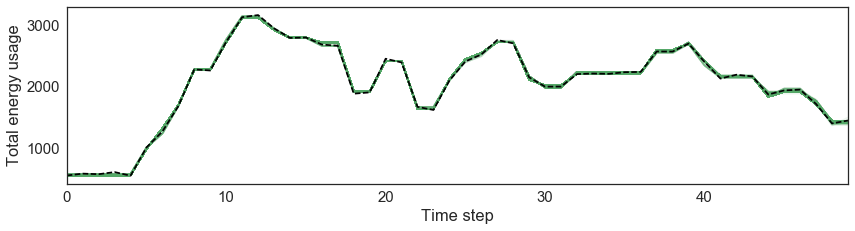

In [10]:
plt.figure(figsize=(14,3.25))

plt.plot(np.dot(X_hat_nn, devices).T, color=sns.color_palette()[1], alpha=0.1)
plt.plot(np.arange(len(Y)), Y,'k--')
plt.xlim([0,T-1])

plt.xlabel('Time step')
plt.ylabel('Total energy usage')

## Look at rate of path coalescence

In [11]:
ANC_PRIOR = []
ANC_NN = []

def count_uniques(ancestry):
    K, T = ancestry.shape
    counts = np.empty((T,), dtype=int)
    for t in xrange(T):
        counts[t] = len(np.unique(ancestry[:,t]))
    return counts

def run_iter():
    X,Y = factorial_hmm.gen_dataset(devices, T=30)
    X_particles_baseline, ancestry_baseline, _ = \
        factorial_hmm.run_smc(devices, Y, 100, factorial_hmm.baseline_proposal, verbose=False)
    print "smc complete"
    X_particles, ancestry_nnsmc, _ = \
        factorial_hmm.run_smc(devices, Y, 500, nn_proposal, verbose=False)
    print "nn complete"
    ANC_PRIOR.append(count_uniques(ancestry_baseline))
    ANC_NN.append(count_uniques(ancestry_nnsmc))
    return X,Y

In [12]:
for i in xrange(10): 
    print "iteration", i+1
    X_tmp, Y_tmp = run_iter()

iteration 1
smc complete
nn complete
iteration 2
smc complete
nn complete
iteration 3
smc complete
nn complete
iteration 4
smc complete
nn complete
iteration 5
smc complete
nn complete
iteration 6
smc complete
nn complete
iteration 7
smc complete
nn complete
iteration 8
smc complete
nn complete
iteration 9
smc complete
nn complete
iteration 10
smc complete
nn complete


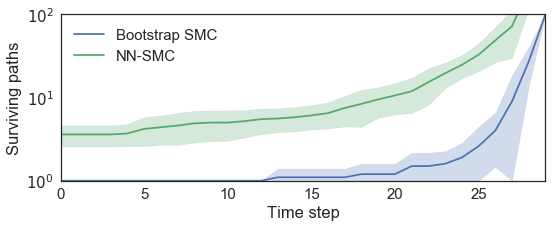

In [13]:
plt.figure(figsize=(8,3.5))
plt.plot(np.arange(len(X_tmp)), np.mean(ANC_PRIOR, 0));
plt.plot(np.arange(len(X_tmp)), np.mean(ANC_NN, 0));
plt.legend(['Bootstrap SMC', 'NN-SMC'], loc='upper left')

pm = np.mean(ANC_PRIOR, 0)
psd = np.std(ANC_PRIOR, 0)
safe_lb = (pm - psd) * (pm - psd > 1.0) + (pm - psd <= 1.0)
plt.fill_between(np.arange(len(X_tmp)), safe_lb, pm+psd, alpha=0.25, color=sns.color_palette()[0]);
pm = np.mean(ANC_NN, 0)
psd = np.std(ANC_NN, 0)
plt.fill_between(np.arange(len(X_tmp)), pm-psd, pm+psd, alpha=0.25, color=sns.color_palette()[1]);

plt.semilogy();
plt.xlabel('Time step')
plt.ylabel('Surviving paths')
plt.ylim(1, 100)
plt.xlim(0, len(X_tmp)-1)

plt.tight_layout()